<a href="https://colab.research.google.com/github/wadduwagelab/All-Optical-QPM/blob/main/Colab/d2nn_pretrained_model_inference_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Colab Setting up Scripts


*   Downloading repository, dataset and models
*   Install pip packages


In [ ]:
!git clone https://github.com/Bantami/All-Optical-QPM.git

!chmod 755 All-Optical-QPM/colab_setup.sh
!All-Optical-QPM/colab_setup.sh


Cloning into 'All-Optical-QPM'...
remote: Enumerating objects: 371, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 371 (delta 14), reused 6 (delta 5), pack-reused 338
Receiving objects: 100% (371/371), 8.76 MiB | 8.33 MiB/s, done.
Resolving deltas: 100% (224/224), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.4/631.4 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00
Downloading...
From: https://drive.google.com/uc?id=16vYiOBYJ8BDCBVHoOv6eqcXaLQhiS8Ik
To: /content/hela.zip
100% 311M/311M [00:02<00:00, 107MB/s]
HeLa dataset downloaded ✔
Downloading...
From: https://drive.google

### Import Libraries

In [ ]:
import sys
sys.path.append('All-Optical-QPM')

from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
from torchvision import datasets, transforms
import math
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import glob
import os
import json

from modules.dataloaders import *
from modules.diffraction import *
from modules.d2nn_models import *
from modules.eval_metrics import *
from modules.vis_utils import *

### Select Pretrained Model and Load it

In [ ]:
## Amp + Phase D2NNs

pretrained_models = {
    'MNIST'       : 'MNIST_d2nn_ap',
    'MNIST[0,2Pi]': 'MNIST_2pi_d2nn_ap',
    'HeLa [0,Pi]' : 'Hela_pi_d2nn_ap',
    'HeLa [0,2Pi]': 'Hela_2pi_d2nn_ap',
    'Bacteria'    : 'Bacteria_d2nn_ap',
}

In [ ]:
def initiate_model(model_name):
  '''
      Function to initiate the model and dataloaders

        Args:
              model_name  : The name of the model - 'MNIST', 'HeLa [0,Pi]', 'HeLa [0,2Pi]', 'Bacteria'

        Returns:
              cfg         : Configurations dictionary
              model       : Initiated model
              val_loader  : Dataloader containing the val images
              test_loader  : Dataloader containing the test images
  '''

  model_name = pretrained_models[model_name] #### Specify which dataset you are considering

  folder = 'models/'

  model_name = f'{model_name}.pth'

  if(model_name == "MNIST_2pi_d2nn_ap.pth"):
    saved = torch.load(folder + model_name, map_location={'cuda:1': 'cuda:0'})
  else:
    saved = torch.load(folder + model_name)

  cfg   = saved['cfg']

  model = eval(cfg['model'])(cfg).to(cfg['device'])
  model.load_state_dict(saved['state_dict'])
  model.eval()

  torch.manual_seed(cfg['torch_seed'])

  shrinkFactor = cfg['shrink_factor'] if 'shrink_factor' in cfg else 1
  img_size     = cfg['img_size']

  if(shrinkFactor!=1):
      csize = int(img_size/shrinkFactor)
      spos  = int((img_size - csize)/2)
      epos  = spos + csize
  else:
      spos = 0
      epos = img_size

  print(cfg['get_dataloaders'])
  dataloader = eval(cfg['get_dataloaders'])


  train_loader, val_loader, test_loader =  dataloader(cfg['img_size'], cfg['train_batch_size'], cfg['torch_seed'],  task_type= cfg['task_type'], shrinkFactor = shrinkFactor, cfg = cfg)
  print(len(test_loader))

  cfg['spos'] = spos
  cfg['epos'] = epos

  return cfg, model, val_loader, test_loader

In [ ]:
def inference(cfg, model, dataloader):
  '''
      Function to infer on unseen data

        Args:
              cfg         : Configurations dictionary
              model       : Initiated model
              dataloader  : Dataloader containing the test images
  '''
  spos = cfg['spos']
  epos = cfg['epos']
  angle_max =  eval(cfg['angle_max'])

  ssim_scores = []
  l1_t = []

  for idx, (x, y) in enumerate(dataloader): #Validation Loop
      gt = x[:,0].to(cfg['device'])
      pred_img, out_scale = model(gt)


      pred_img = pred_img[:,spos:epos,spos:epos] # Crop the pred image
      gt       = gt[:,spos:epos,spos:epos]       # Crop the groundtruth image


      pred_out = out_scale * pred_img.abs()**2

      if(cfg['get_dataloaders']=="get_mnist_dataloaders"):
          gt_angle = (gt.angle()%(2*np.pi))/angle_max
      else:
          gt_angle = y[:,0].to(cfg['device'])[:,spos:epos,spos:epos] / angle_max

      ssim_scores.append(ssim_pytorch(pred_out, gt_angle, k= 11,range_independent=False))
      l1_t.append(L1_distance(pred_out, gt_angle))

  print("========\nMean SSIM = ", np.mean(ssim_scores))
  print("========\nMean L1 = ", np.mean(l1_t))


  gt_img_set = gt_angle.unsqueeze(dim= 1)[10:14]
  k = gt_img_set.detach().cpu()
  k = cv2.cvtColor(make_grid(k, nrow=2, padding= 1).permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY)%(2*np.pi)

  if cfg['get_dataloaders'] == 'get_bacteria_dataloaders': # To visualize bacteria reconstruction clearly
      pred_vmax = 0.13
  else:
      pred_vmax = 1

  ## Plot Input
  plt.figure(figsize=(4,4))
  plt.title("Grountruth Phase")
  plt.imshow(k,vmin=0, vmax = pred_vmax)
  plt.colorbar()

  ## Plot Output
  pred_img_set = pred_out.unsqueeze(dim= 1)[10:14]
  plt.figure(figsize=(4,4))
  plt.imshow(cv2.cvtColor(make_grid(pred_img_set.abs().detach().cpu(), nrow=2, padding= 1).permute(1,2,0).numpy(), cv2.COLOR_RGB2GRAY),vmin = 0, vmax = pred_vmax)
  plt.colorbar()

  plt.title('Reconstructed : Intensity')

#### MNIST

No learnable transmission coefficients
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
get_mnist_dataloaders


100%|██████████| 9912422/9912422 [00:00<00:00, 89069178.72it/s]

Extracting /n/holyscratch01/wadduwage_lab/fypteam_22/datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /n/holyscratch01/wadduwage_lab/fypteam_22/datasets/mnist/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 80063247.74it/s]


Extracting /n/holyscratch01/wadduwage_lab/fypteam_22/datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /n/holyscratch01/wadduwage_lab/fypteam_22/datasets/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 49662078.55it/s]


Extracting /n/holyscratch01/wadduwage_lab/fypteam_22/datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /n/holyscratch01/wadduwage_lab/fypteam_22/datasets/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20707096.49it/s]


Extracting /n/holyscratch01/wadduwage_lab/fypteam_22/datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /n/holyscratch01/wadduwage_lab/fypteam_22/datasets/mnist/MNIST/raw

312
Mean SSIM =  0.9433060091657516
Mean L1 =  0.02010629858033588


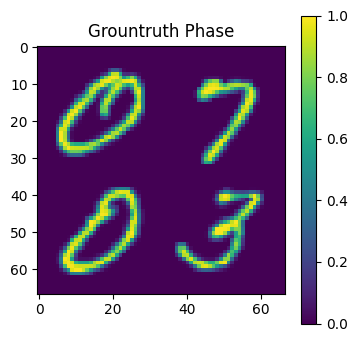

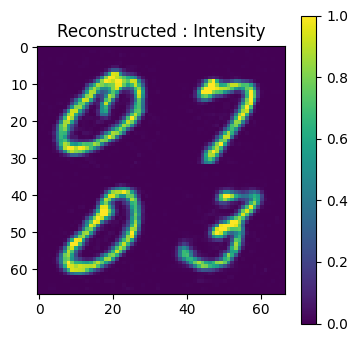

In [ ]:
cfg, model, val_loader, test_loader = initiate_model('MNIST')
inference(cfg, model, test_loader)

#### MNIST [0, 2Pi]

In [ ]:
cfg, model, val_loader, test_loader = initiate_model("MNIST[0,2Pi]")
inference(cfg, model, test_loader)

#### HeLa [0, $\pi$]

In [ ]:
cfg, model, val_loader, test_loader = initiate_model('HeLa [0,Pi]')
inference(cfg, model, test_loader)

#### HeLa [0, $2\pi$]

In [ ]:
cfg, model, val_loader, test_loader = initiate_model('HeLa [0,2Pi]')
inference(cfg, model, test_loader)

### Bacteria

No learnable transmission coefficients
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
Learnable transmission coefficient: Amplitude and Phase
get_bacteria_dataloaders
228
Mean SSIM =  0.9925582482103716
Mean L1 =  0.0006681757298984417


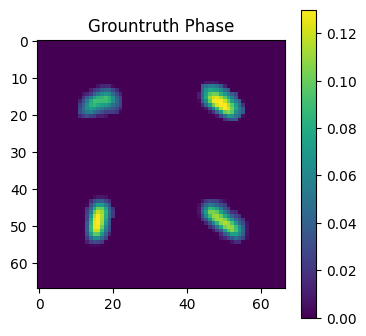

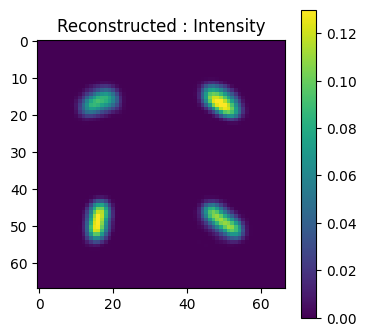

In [ ]:
cfg, model, val_loader, test_loader = initiate_model('Bacteria')
inference(cfg, model, test_loader)